# BlowBy Diag with MILEA
Context : PSA request blowby diag for USA & Korea applications. Current platform SW do not match PSA specs.

Different engine Fields has been performed with different configurations.
Test cases 1, 7 and 8 should be not diaged
Test cases 2, 3, 7bis and 8bis should be diaged

In the CSV files of train / test sets are described bellow :

For all the datasets :
 - col 1 : RPM
 - col 2 : load
 - col 3 : conf (number in [1 2 3 7 8 10 11]) > 7 classes corresponding to the engine field
 - col 4 : if the blowby is leaking or not (number in [0 1]) > binary classification
 - col 5 : engine Load
 - col 5 > 51 : 46 * 5 Cranck angle based Pressure for new sensor in the blowby system
 - col 52 > 98 : 46 * 5 Cranck angle based Pressure for Outlet compressor sensor
 - 99 > 145 : 46 * 5 Cranck angle based Pressure for inlet manifold sensor
 
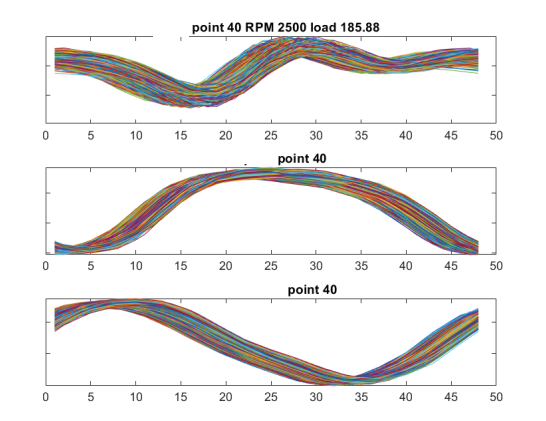


# Datasets 

 - DS1 : same OP
 - DS2 : different OP

## Enviroment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint 
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import kerastuner as kt
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

ModuleNotFoundError: No module named 'keras'

## Import data & splitting

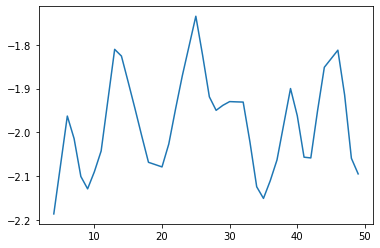

In [2]:
data = pd.read_csv('TrainSet1_sameOP.csv', header=None)
test = pd.read_csv('TestSet1_sameOP.csv', header=None)

data = data.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})
test = test.rename(columns = {0:'RPM',1:'load',2:'conf',3:'bin'})

one = data.iloc[:,4:50]
two = data.iloc[:,51:97]
three = data.iloc[:,98:144]

dic_map_class = {1:"1",
                2:"2",
                3:"3",
                4:"4",
                5:"5",
                6:"5bis",
                7:"7",
                8:"8bis",
                9:"9",
                10:"8",
                11:"7bis"}

def mapping(inp):
    return dic_map_class[inp]

data["class_target_str"] = data["conf"].apply(mapping)
test["class_target_str"] = test["conf"].apply(mapping)

def myround(x, base=50):
    return base * round(x/base)
data['round_RPM'] = data['RPM'].apply(myround)
test['round_RPM'] = test['RPM'].apply(myround)

one.iloc[1,:].plot()

data=data.dropna()
data=data[(data['round_RPM'] < 3500) & (data['load']>30) & (data['round_RPM'] >1400)]
test=test.dropna()
test=test[(test['round_RPM'] < 3500) & (test['load']>30) & (test['round_RPM'] >1400)]

In [3]:
X_train = data.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[data.dropna()['round_RPM'] < 3500]
X_test = test.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()
y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
print(X_train.shape)
print(y_train.shape)
X_train.head()

(234301, 143)
(234301,)


,RPM,load,4,5,6,7,8,9,10,11,...,135,136,137,138,139,140,141,142,143,144
16414,1499.4,31.759,-1.4216,-1.3352,-1.2491,-1.16370,-0.91733,-0.52674,-0.28768,-0.09588,...,-344.15,-332.11,-318.54,-299.87,-282.87,-267.85,-258.80,-252.44,-251.51,-251.55
16415,1499.4,31.759,-1.3681,-1.3231,-1.1219,-0.96334,-0.82952,-0.65475,-0.48898,-0.45058,...,-349.88,-339.67,-324.06,-305.89,-286.05,-272.85,-261.56,-257.92,-255.75,-256.79
16416,1499.4,31.759,-1.2184,-1.3006,-1.2095,-1.06890,-0.79906,-0.61281,-0.62157,-0.55977,...,-354.24,-344.82,-327.62,-309.82,-290.34,-276.21,-267.12,-264.55,-264.02,-265.69
16417,1499.4,31.759,-1.4354,-1.3137,-1.1899,-1.06380,-0.95126,-0.84461,-0.67303,-0.50886,...,-352.32,-339.61,-325.60,-306.71,-289.91,-276.54,-267.79,-262.12,-260.78,-260.53
16418,1499.4,31.759,-1.3973,-1.2214,-1.1389,-1.01240,-0.84751,-0.61073,-0.35705,-0.27070,...,-346.45,-334.03,-317.05,-299.00,-280.40,-269.26,-260.07,-257.58,-256.77,-258.55


In [4]:
def clean_data(data):
    X_train = data.drop(['conf','bin','class_target_str','round_RPM'], axis=1).dropna()[data.dropna()['round_RPM'] < 3500]
    y_train = data.dropna()['bin']
    conf_train = data.dropna()['class_target_str']
    return (X_train, y_train, conf_train)

In [5]:
X_train, y_train, conf_train = clean_data(data)
X_test, y_test, conf_test = clean_data(test)

In [6]:
X_train.columns[-20:]

Index([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144],
      dtype='object')

In [7]:
X_test.columns[-20:]

Index([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144],
      dtype='object')

## Feature engineering and feature selection

In [8]:
one = X_train.iloc[:,4:50] 
two = X_train.iloc[:,51:97] 
three = X_train.iloc[:,98:144]
X_train['min_s1'] = one.min(axis=1)
X_train['min_s2'] = two.min(axis=1)
X_train['min_s3'] = three.min(axis=1)
X_train['max_s1'] = one.max(axis=1)
X_train['max_s2'] = two.max(axis=1)
X_train['max_s3'] = three.max(axis=1)
X_train['mean_s1'] = one.mean(axis=1)
X_train['mean_s2'] = two.mean(axis=1)
X_train['mean_s3'] = three.mean(axis=1)
X_train['std_s1'] = one.std(axis=1)
X_train['std_s2'] = two.std(axis=1)
X_train['std_s3'] = three.std(axis=1)
X_train['argmin_s1']=one.apply(np.argmin,axis=1)
X_train['argmin_s2']=two.apply(np.argmin,axis=1)
X_train['argmin_s3']=three.apply(np.argmin,axis=1)
X_train['argmax_s1']=one.apply(np.argmin,axis=1)
X_train['argmax_s2']=two.apply(np.argmin,axis=1)
X_train['argmax_s3']=three.apply(np.argmin,axis=1)

In [9]:
one = X_test.iloc[:,4:50] 
two = X_test.iloc[:,51:97] 
three = X_test.iloc[:,98:144]
X_test['min_s1'] = one.min(axis=1)
X_test['min_s2'] = two.min(axis=1)
X_test['min_s3'] = three.min(axis=1)
X_test['max_s1'] = one.max(axis=1)
X_test['max_s2'] = two.max(axis=1)
X_test['max_s3'] = three.max(axis=1)
X_test['mean_s1'] = one.mean(axis=1)
X_test['mean_s2'] = two.mean(axis=1)
X_test['mean_s3'] = three.mean(axis=1)
X_test['std_s1'] = one.std(axis=1)
X_test['std_s2'] = two.std(axis=1)
X_test['std_s3'] = three.std(axis=1)
X_test['argmin_s1']=one.apply(np.argmin,axis=1)
X_test['argmin_s2']=two.apply(np.argmin,axis=1)
X_test['argmin_s3']=three.apply(np.argmin,axis=1)
X_test['argmax_s1']=one.apply(np.argmin,axis=1)
X_test['argmax_s2']=two.apply(np.argmin,axis=1)
X_test['argmax_s3']=three.apply(np.argmin,axis=1)

In [19]:
plt.figure()
for i in range(0,one[y_train==1].shape[0],500):
    plt.scatter(i,one[y_train==1].argmin(axis=1)[i],color='r')
for i in range(0,one[y_train==0].shape[0],500):
    plt.scatter(i,one[y_train==0].argmin(axis=1)[i],color='b')

C:\Users\94541\Anaconda3\envs\pytorch1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>


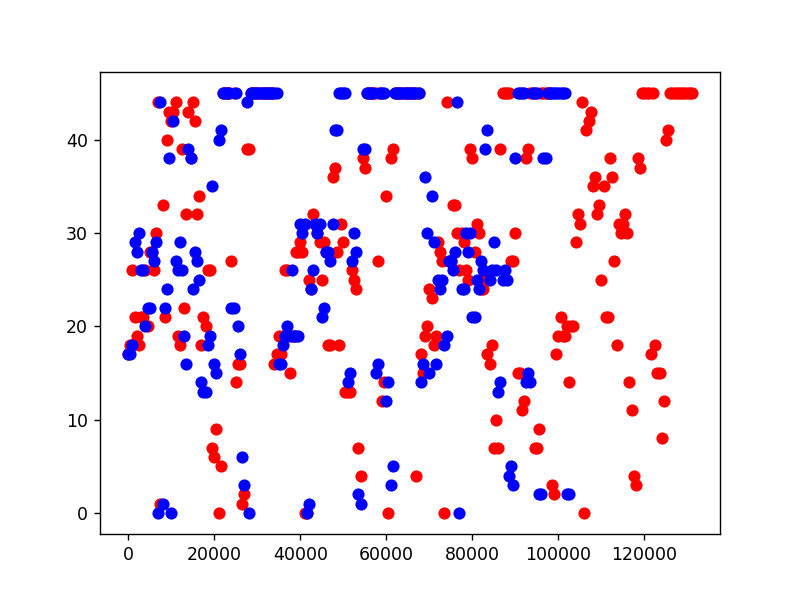

In [106]:
plt.figure()
for i in range(0,one[y_train==1].shape[0],500):
    plt.scatter(i,one[y_train==1].argmax(axis=1)[i],color='r')
for i in range(0,one[y_train==0].shape[0],500):
    plt.scatter(i,one[y_train==0].argmax(axis=1)[i],color='b')

In [20]:
X_train

,RPM,load,4,5,6,7,8,9,10,11,...,mean_s3,std_s1,std_s2,std_s3,argmin_s1,argmin_s2,argmin_s3,argmax_s1,argmax_s2,argmax_s3
16414,1499.4,31.759,-1.4216,-1.33520,-1.24910,-1.16370,-0.91733,-0.52674,-0.28768,-0.09588,...,-326.722222,1.113779,37.250333,42.236759,37,45,24,37,45,24
16415,1499.4,31.759,-1.3681,-1.32310,-1.12190,-0.96334,-0.82952,-0.65475,-0.48898,-0.45058,...,-331.327333,0.898302,38.004582,42.261652,27,45,25,27,45,25
16416,1499.4,31.759,-1.2184,-1.30060,-1.20950,-1.06890,-0.79906,-0.61281,-0.62157,-0.55977,...,-337.084000,0.967565,38.743018,42.146821,29,45,25,29,45,25
16417,1499.4,31.759,-1.4354,-1.31370,-1.18990,-1.06380,-0.95126,-0.84461,-0.67303,-0.50886,...,-338.936000,1.005803,39.929687,41.368041,30,45,24,30,45,24
16418,1499.4,31.759,-1.3973,-1.22140,-1.13890,-1.01240,-0.84751,-0.61073,-0.35705,-0.27070,...,-332.623556,1.046738,39.213361,41.671320,34,45,24,34,45,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603187,1751.8,202.410,-2.9452,-0.71981,1.08890,2.22190,3.45730,4.90200,5.91680,5.80390,...,1543.857778,247.958251,126.187634,50.640118,25,17,1,25,17,1
603188,1751.8,202.410,-2.3364,1.25840,4.63420,7.08750,9.28230,10.07900,10.68900,9.92620,...,1549.100000,245.880704,124.621890,43.326708,29,15,44,29,15,44
603189,1751.8,202.410,-2.3839,0.52677,3.09780,4.93090,6.53940,7.42200,8.11560,7.79850,...,1548.657778,244.164223,124.124048,49.230033,31,15,0,31,15,0
603190,1751.8,202.410,-4.6397,-1.93280,0.78403,2.80460,4.32670,5.49960,6.39000,6.63700,...,1545.506667,248.330323,126.581484,50.703023,23,16,2,23,16,2


## Scale the data

In [21]:
X_trainEng = X_train[data['round_RPM'] < 3500][['RPM','load',
                        'min_s1','min_s2','min_s3',
                        'max_s1','max_s2','max_s3',
                        'mean_s1','mean_s2','mean_s3',
                        'std_s1','std_s2','std_s3','argmin_s1'
                         ,'argmin_s2','argmin_s3','argmax_s1',
                            'argmax_s2','argmax_s3']]
X_testEng = X_test[test['round_RPM'] < 3500][['RPM','load',
                        'min_s1','min_s2','min_s3',
                        'max_s1','max_s2','max_s3',
                        'mean_s1','mean_s2','mean_s3',
                        'std_s1','std_s2','std_s3','argmin_s1'
                         ,'argmin_s2','argmin_s3','argmax_s1',
                            'argmax_s2','argmax_s3']]

y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
print(X_trainEng.shape)
print(y_train.shape)
X_train.head()
scaler = StandardScaler()
scaler.fit(X_trainEng)
X_trainS = scaler.transform(X_trainEng)
scaler.fit(X_testEng)
X_testS = scaler.transform(X_testEng)

(234301, 20)
(234301,)


<IPython.core.display.Javascript object>


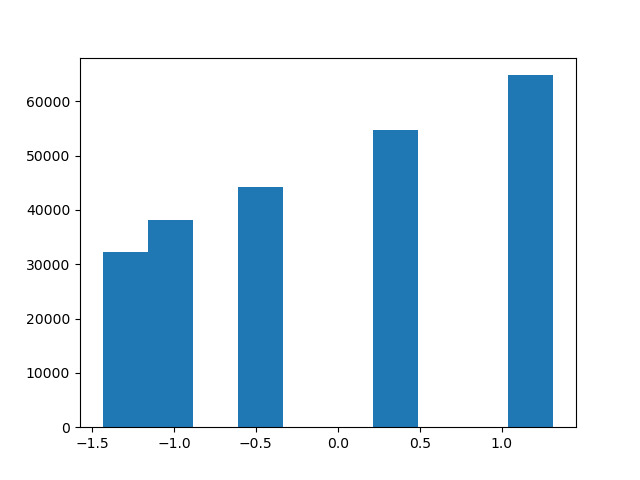

(array([32321., 38197.,     0., 44191.,     0.,     0., 54797.,     0.,
            0., 64795.]),
 array([-1.43552632, -1.16038779, -0.88524925, -0.61011071, -0.33497217,
        -0.05983363,  0.21530491,  0.49044345,  0.76558199,  1.04072053,
         1.31585907]),
 <BarContainer object of 10 artists>)

In [22]:
%matplotlib notebook
plt.figure()
plt.hist(X_trainS[:,0],bins=10)

<IPython.core.display.Javascript object>


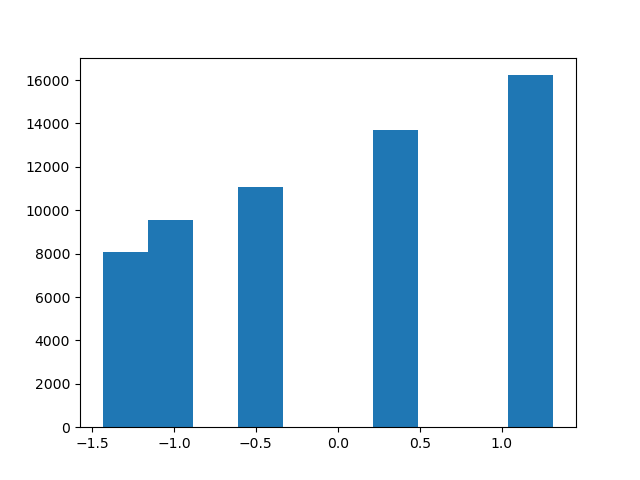

(array([ 8099.,  9563.,     0., 11069.,     0.,     0., 13722.,     0.,
            0., 16226.]),
 array([-1.4353659 , -1.16023638, -0.88510687, -0.60997735, -0.33484784,
        -0.05971832,  0.21541119,  0.49054071,  0.76567022,  1.04079973,
         1.31592925]),
 <BarContainer object of 10 artists>)

In [23]:
plt.figure()
plt.hist(X_testS[:,0],bins=10)

In [161]:
# feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
rfe = RFE(clf,n_features_to_select=5)
rfe.fit(X_trainS, y_train)
feature_idx = rfe.get_support()
print(feature_idx)

[ True  True  True False False False False  True  True False False False
 False False False False False False False False]


In [186]:
X_trainS_5fts=X_trainS[:,[0,1,2,7,8]]
X_testS_5fts=X_testS[:,[0,1,2,7,8]]

In [54]:
def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu',input_shape=(5,))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy,
                metrics=['recall'])
    return model

SyntaxError: invalid syntax (<ipython-input-54-98979f9e9f2f>, line 5)

In [238]:
def model_builder(hp):
    model = keras.Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-1024
    model.add(Dense(units=70, activation='relu'))
    hp_units = hp.Int('units', min_value=10, max_value=100, step=20)
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(units=20, activation='relu'))
    model.add((Dense(1, activation='sigmoid')))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics='accuracy')
    return model

In [239]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir2',)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
tuner.search(X_trainS_5fts,y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 21 Complete [00h 00m 57s]
val_accuracy: 0.1911824345588684

Best val_accuracy So Far: 0.20151084661483765
Total elapsed time: 00h 13m 21s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f""" {best_hps.get('units')}  {best_hps.get('learning_rate')}.
""")

In [327]:
def build_classification_model():
    model = keras.Sequential()
    model.add(Dense(units=70,activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=20, activation='relu'))
    model.add((Dense(1, activation='sigmoid')))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics='accuracy')
    return model

In [328]:
model=build_classification_model()

In [331]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 70)                420       
_________________________________________________________________
dense_108 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_109 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 21        
Total params: 5,011
Trainable params: 5,011
Non-trainable params: 0
_________________________________________________________________


In [329]:
history=model.fit(np.array(X_trainS_5fts), np.array(y_train), epochs=30,
                  validation_data=(X_testS_5fts,y_test),callbacks=[stop_early])

Epoch 1/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.3385 - accuracy: 0.8264 - val_loss: 0.2788 - val_accuracy: 0.8618
Epoch 2/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.2423 - accuracy: 0.8847 - val_loss: 0.2086 - val_accuracy: 0.9040
Epoch 3/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.1963 - accuracy: 0.9108 - val_loss: 0.2192 - val_accuracy: 0.9002
Epoch 4/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.1707 - accuracy: 0.9255 - val_loss: 0.1713 - val_accuracy: 0.9233
Epoch 5/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.1567 - accuracy: 0.9321 - val_loss: 0.1696 - val_accuracy: 0.9260
Epoch 6/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.1463 - accuracy: 0.9380 - val_loss: 0.2153 - val_accuracy: 0.9077
Epoch 7/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.1392 - accuracy: 0.9409 - val_loss: 0.1828 - val_accuracy:

<IPython.core.display.Javascript object>


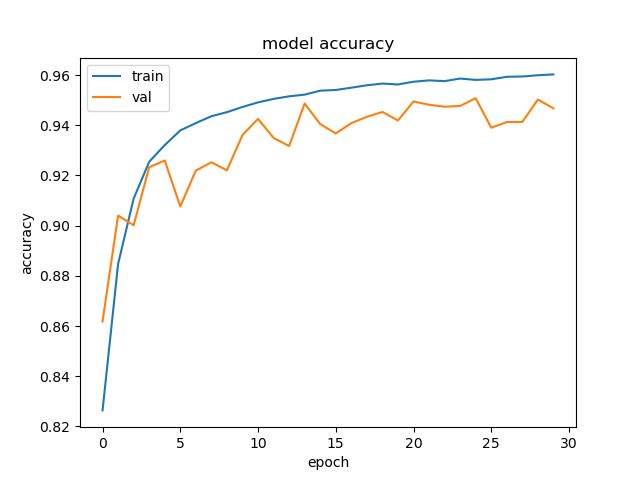

In [330]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## without sensor 1

In [10]:
X_trainEngwo1 = X_train[data['round_RPM'] < 3500][['RPM','load','min_s2','min_s3','max_s2','max_s3','mean_s2','mean_s3','std_s2','std_s3','argmin_s2','argmin_s3','argmax_s2','argmax_s3']]
X_testEngwo1 = X_test[test['round_RPM'] < 3500][['RPM','load','min_s2','min_s3','max_s2','max_s3','mean_s2','mean_s3','std_s2','std_s3','argmin_s2','argmin_s3','argmax_s2','argmax_s3']]
y_train = data.dropna()['bin']
y_test = test.dropna()['bin']
conf_train = data.dropna()['class_target_str']
conf_test = test.dropna()['class_target_str']
X_train.head()
scaler = StandardScaler()
scaler.fit(X_trainEngwo1)
X_trainSwo1 = scaler.transform(X_trainEngwo1)
scaler.fit(X_testEngwo1)
X_testSwo1 = scaler.transform(X_testEngwo1)

In [11]:
print(X_trainSwo1)

[[-1.43388087 -1.4061943  -1.3118682  ...  0.3343726   0.98141892
   0.3343726 ]
 [-1.43388087 -1.4061943  -1.32124771 ...  0.4318518   0.98141892
   0.4318518 ]
 [-1.43388087 -1.4061943  -1.33008713 ...  0.4318518   0.98141892
   0.4318518 ]
 ...
 [-0.97242185  1.70195002  1.67610734 ... -2.0051281  -0.94961861
  -2.0051281 ]
 [-0.97242185  1.70195002  1.66980633 ... -1.81016971 -0.88525069
  -1.81016971]
 [-0.97242185  1.70195002  1.67790763 ...  2.28395652 -0.88525069
   2.28395652]]


In [12]:
# feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
rfe = RFE(clf,n_features_to_select=5)
rfe.fit(X_trainSwo1, y_train)
feature_idx = rfe.get_support()
print(feature_idx)

[ True  True False  True  True False  True False False False False False
 False False]


In [20]:
X_trainSwo1_5fts=X_trainSwo1[:,feature_idx]
X_testSwo1_5fts=X_testSwo1[:,feature_idx]

In [22]:
X_trainSwo1_5fts.shape


(234301, 5)

In [23]:
def build_classification_model():
    model = keras.Sequential()
    model.add(Dense(units=70,activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=20, activation='relu'))
    model.add((Dense(1, activation='sigmoid')))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics='accuracy')
    return model

In [24]:
model1=build_classification_model()

In [26]:
history1=model1.fit(np.array(X_trainSwo1_5fts), np.array(y_train), epochs=30,
                  validation_data=(X_testSwo1_5fts,y_test))

Epoch 1/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.6590 - accuracy: 0.5966 - val_loss: 0.5973 - val_accuracy: 0.6675
Epoch 2/30
7322/7322 [==============================] - 8s 1ms/step - loss: 0.4922 - accuracy: 0.7471 - val_loss: 0.4421 - val_accuracy: 0.7770
Epoch 3/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.4382 - accuracy: 0.7769 - val_loss: 0.4863 - val_accuracy: 0.7615
Epoch 4/30
7322/7322 [==============================] - 8s 1ms/step - loss: 0.4137 - accuracy: 0.7914 - val_loss: 0.4342 - val_accuracy: 0.7866
Epoch 5/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.3920 - accuracy: 0.8053 - val_loss: 0.3684 - val_accuracy: 0.8296
Epoch 6/30
7322/7322 [==============================] - 8s 1ms/step - loss: 0.3834 - accuracy: 0.8117 - val_loss: 0.3407 - val_accuracy: 0.8384
Epoch 7/30
7322/7322 [==============================] - 9s 1ms/step - loss: 0.3692 - accuracy: 0.8189 - val_loss: 0.3543 - val_accuracy:

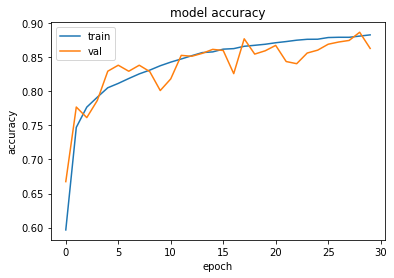

In [27]:
plt.figure()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 70)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 5,011
Trainable params: 5,011
Non-trainable params: 0
_________________________________________________________________
